In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join, exists
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import LinearRegression

In [2]:
sns.set(style='whitegrid', context='talk')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier New'

In [3]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [4]:
imputed_cdk = pd.read_csv(join(join(PROJ_DIR, DATA_DIR, "desikankillany_MICEimputed_data.csv")), 
                          index_col='subjectkey', 
                          header=0)
imputed_dcg = pd.read_csv(join(join(PROJ_DIR, DATA_DIR, "destrieux+gordon_MICEimputed_data.csv")), 
                          index_col='subjectkey', 
                          header=0)

In [5]:
n_iter = 10
max_k = 10
k_split = 10
labels = {}
index = pd.MultiIndex.from_product((range(0,n_iter), range(0, k_split)))
log_likelihood = pd.DataFrame(index=index, 
                              columns=range(2,max_k))

In [89]:
atlases = {'desikankillany': imputed_cdk,
           'destrieux+gordon': imputed_dcg}

In [90]:
parameter_grid = {
    'weight_concentration_prior_type': [
        'dirichlet_process', 
        'dirichlet_distribution'],
    'weight_concentration_prior': [
        10**-1,
        10**0,
        10**1, 
        10**2, 
        10**3, 
        10**4, 
        10**5
    ],
    'n_components': list(range(2,11))
}

estimator = BayesianGaussianMixture(
    max_iter=1000
)

In [91]:
# hyper parameter tuning
for atlas in atlases.keys():
    data = atlases[atlas]
    # need train test split
    train, test = train_test_split(data, train_size=0.5)
    train_df = pd.DataFrame(train)
    test_df = pd.DataFrame(test)
    search = HalvingGridSearchCV(estimator, 
                                parameter_grid, 
                                factor=3, 
                                cv=10, 
                                n_jobs=-1).fit(train_df)
    best_params = pd.Series(search.best_estimator_.get_params())
    best_params['test_score'] = search.best_estimator_.score(test_df)
    best_params.to_csv(join(PROJ_DIR,
                            OUTP_DIR,
                            f'bgmm_{atlas}_best-model.csv'))
    results = pd.DataFrame.from_dict(search.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.to_csv(join(PROJ_DIR, 
                        OUTP_DIR, 
                        f'bgmm_{atlas}_cv-results.csv'))
    scores_matrix = results.sort_values("iter").pivot_table(
                index="param_weight_concentration_prior",
                columns="param_n_components",
                values="mean_test_score",
                aggfunc="last",
            )
    plt.tight_layout()
    sns.heatmap(scores_matrix, 
                cmap='viridis').savefig(join(PROJ_DIR, 
                                             FIGS_DIR, 
                                             f'bgmm_{atlas}_cv-scores.png'), 
                                        dpi=400)
    labels = search.best_estimator_.fit(data)
    labels_df = pd.Series(labels, index=data.index)
    labels_df.to_csv(join(PROJ_DIR, 
                        OUTP_DIR, 
                        f'bgmm_{atlas}_labels.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/output/bgmm_desikankillany_cv-results.csv'

In [ ]:
# outdated
# parameter iterating here is replaced by halving grid search above
# yay hyperparameter tuning

for atlas in atlases.keys():
    manager = enlighten.get_manager()
    tocks = manager.counter(total=max_k-2, 
                            desc='Number of Components', 
                            unit='k')

    for k in range(2,max_k+1):
        ticks = manager.counter(total=n_iter * k_split, desc='Iterations', unit='iters')
        for i in range(0,n_iter):
            # should be doing k-folds cv instead of split-half
            # need to adress this in the prereg, too
            data = atlases[atlas]
            all_ppts = list(data.index)
            kf = KFold(n_splits=k_split)
            lls = []
            j = 0
            for train, test in kf.split(all_ppts):
                train_df = data.iloc[train]
                test_df = data.iloc[test]
                bgmm = BayesianGaussianMixture(n_components=k,
                                               weight_concentration_prior_type='dirichlet_process',
                                               weight_concentration_prior=10**4,
                                               max_iter=1000).fit(train_df)
                log_likelihood.at[(i,j),k] = bgmm.score(test_df)
                if bgmm.converged_ == False:
                    print(k, f'iteration {i}', 'did not converge')
                ticks.update()
                j += 1

        ticks.close()
        tocks.update()
        #label = bgmm.predict(imputed_cdk)
        #labels[k] = pd.Series(label, index=imputed_cdk.index)
    ll_long = log_likelihood.melt(value_vars=list(range(2,max_k+1)), 
                              value_name='Log Likelihood', 
                              var_name='k')
    ll_long['k'] = ll_long['k'] - 2
    fig,ax = plt.subplots(figsize=(10,7))
    sns.lineplot(x='k', 
                 y='Log Likelihood', 
                 data=ll_long, 
                 ax=ax)
    sns.stripplot(data=log_likelihood, dodge=True, ax=ax)
    plt.tight_layout()
    fig.savefig(f'../figures/gmm_{atlas}_loglikelihood.png', dpi=400)

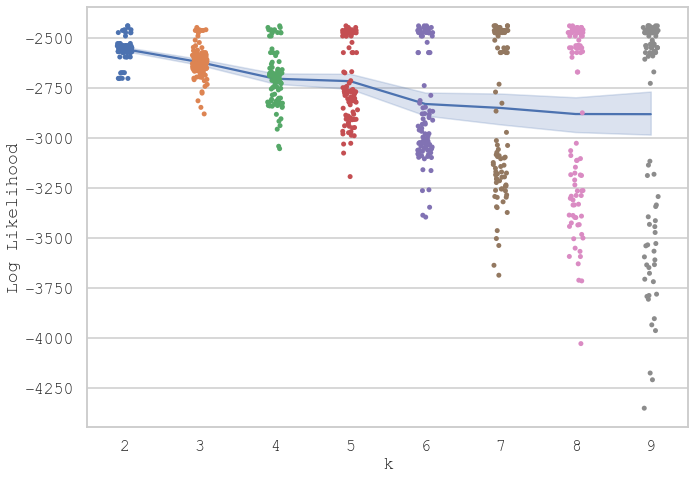

In [12]:
ll_long = log_likelihood.melt(value_vars=[2,3,4,5,6,7,8,9], 
                          value_name='Log Likelihood', 
                          var_name='k')
ll_long['k'] = ll_long['k'] - 2
fig,ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='k', 
             y='Log Likelihood', 
             data=ll_long, 
             ax=ax)
sns.stripplot(data=log_likelihood, dodge=True, ax=ax)
plt.tight_layout()
fig.savefig(f'../figures/gmm_{atlas}_loglikelihood.png', dpi=400)

In [101]:
pd.Series(g.predict(data), index=data.index)

subjectkey
NDAR_INV022ZVCT8    0
NDAR_INV08J0E48V    0
NDAR_INV08K0R9C4    1
NDAR_INV08P3GNDV    0
NDAR_INV08R2PTT1    0
                   ..
NDAR_INVZTPV9V4Z    1
NDAR_INVZN4F9J96    1
NDAR_INVZPRTF377    1
NDAR_INVZMMR8GE2    1
NDAR_INVZM2Y9JCA    0
Length: 7802, dtype: int64